In [2]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience


import pims
import trackpy as tp
import av

# Import video or single image as an array of frames

In [3]:
frames = pims.as_grey(pims.PyAVReaderTimed("videos/1.5g@30Hz_long.mp4"))#pims.PyAVReaderTimed("videos/1.5g@30Hz_long.mp4")#

show frame 0

(850, 478)
[[201.6491 203.6491 202.6491 ... 181.2942 181.2942 181.2942]
 [203.6491 206.6491 205.6491 ... 180.2942 180.2942 180.2942]
 [203.6491 207.6491 208.6491 ... 181.2942 181.2942 182.2942]
 ...
 [205.066  204.066  195.066  ...  36.5768  36.5768  36.5768]
 [205.2102 198.2102 197.2102 ...  38.148   38.148   38.148 ]
 [201.2102 195.2102 194.2102 ...  38.148   38.148   38.148 ]]


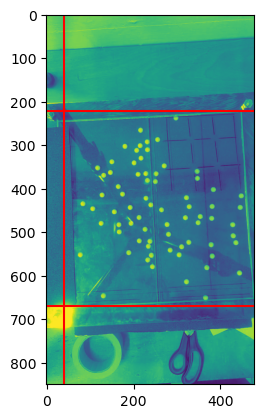

In [4]:
plt.imshow(frames[100])
plt.axvline(40, c='r')
plt.axhline(220, c='r')
plt.axhline(670, c='r')

print(frames[0].shape)
print(frames[0])

In [5]:
y = np.array([1, 2, 3, 5, 6, 7])
print(y[1:6])

[2 3 5 6 7]


In [6]:
print(type(frames))
new_frames = np.zeros(shape=len(frames), dtype=pims.Frame)

print(new_frames)
new_frames[0] = frames[0]
print(new_frames)

for i in range(len(new_frames)):
    new_frames[i] = frames[i][220:670, 40:-1]
#print(np.shape(new_frames))


<class 'slicerator.Pipeline'>
[0 0 0 ... 0 0 0]
[Frame([[201.6491, 203.6491, 202.6491, ..., 181.2942, 181.2942, 181.2942],
        [203.6491, 206.6491, 205.6491, ..., 180.2942, 180.2942, 180.2942],
        [203.6491, 207.6491, 208.6491, ..., 181.2942, 181.2942, 182.2942],
        ...,
        [205.066 , 204.066 , 195.066 , ...,  36.5768,  36.5768,  36.5768],
        [205.2102, 198.2102, 197.2102, ...,  38.148 ,  38.148 ,  38.148 ],
        [201.2102, 195.2102, 194.2102, ...,  38.148 ,  38.148 ,  38.148 ]])
 0 0 ... 0 0 0]


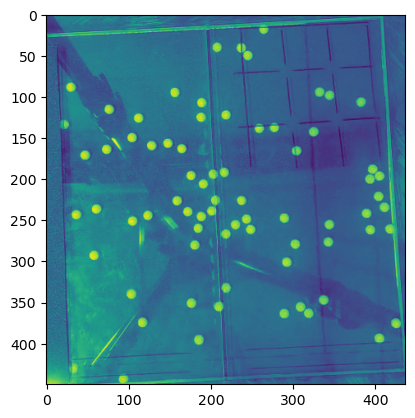

In [7]:
plt.imshow(new_frames[0])

crop unwanted parts from video

In [8]:
print(frames.frame_shape) # y, x, number of colours (I think), this is not modified by .as_grey()
print(len(frames))

print(new_frames[0].shape) # y, x


(850, 478, 3)
2139
(450, 437)


In [74]:
fps = 30
total_frames = len(new_frames)
duration = total_frames/fps

container = av.open("test.mp4", mode="w")

stream = container.add_stream("mpeg4", rate=fps)
stream.width = new_frames[0].shape[1]*2
stream.height = new_frames[0].shape[0]*2
stream.pix_fmt = "yuv420p"

for i in range(total_frames):

    img = new_frames[i]
    img = np.round(img)#.astype(np.uint16)
    frame = av.VideoFrame.from_ndarray(img, format="rgb24")
    for packet in stream.encode(frame):
        container.mux(packet)

# Flush stream
for packet in stream.encode():
    container.mux(packet)

# Close the file
container.close()

In [31]:
#frames1= crop_frames(frames, x_range=(40,-1), y_range=(220,670))
frames1 = pims.process.crop(frames, ((40, 180), (40, 0), (0, 0)))

print(frames1.frame_shape)
print(frames1.shape)

(630, 438, 3)


AttributeError: No attribute `shape` propagated.

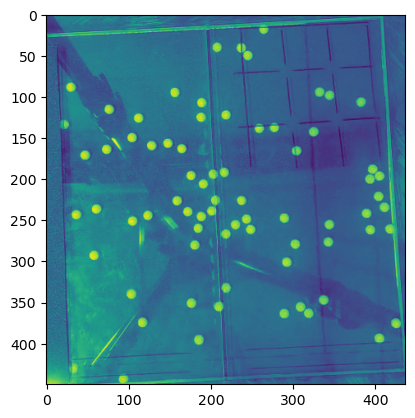

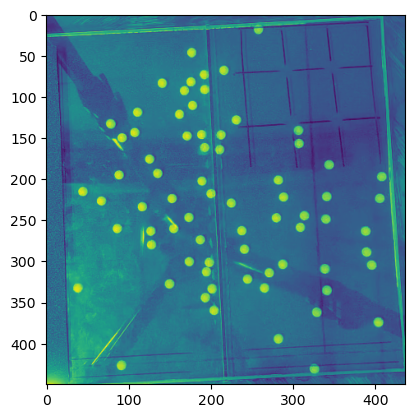

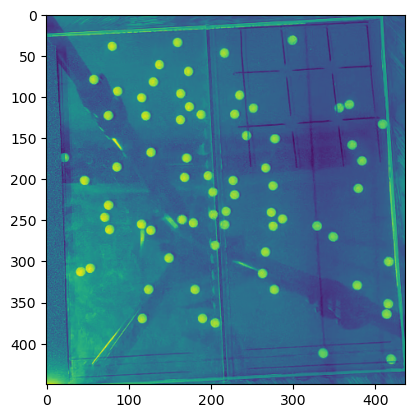

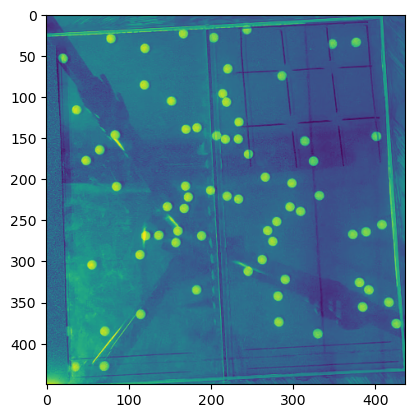

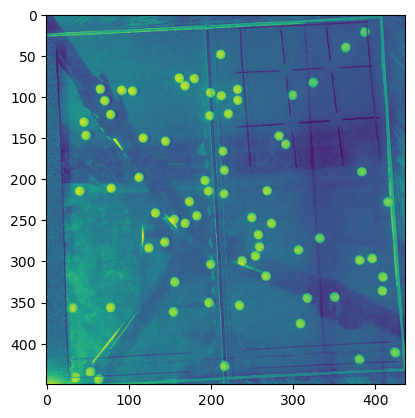

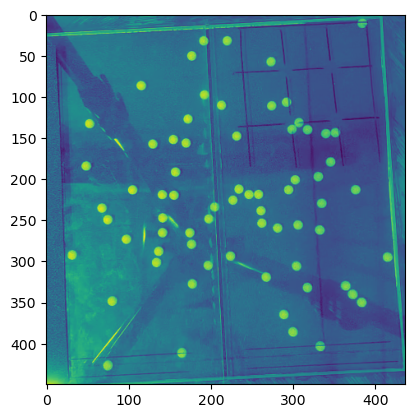

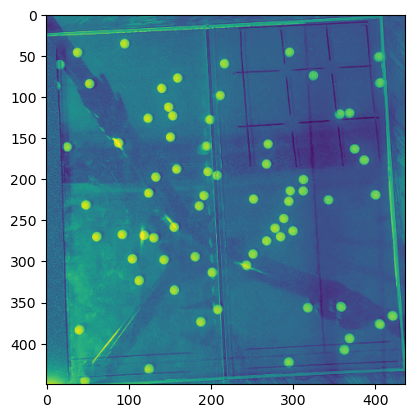

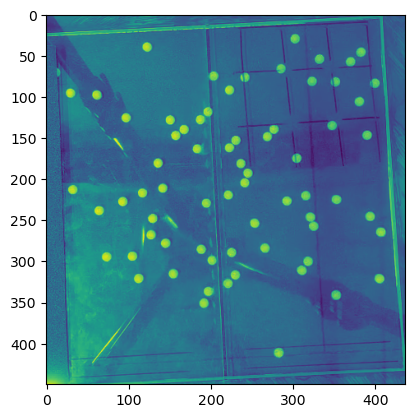

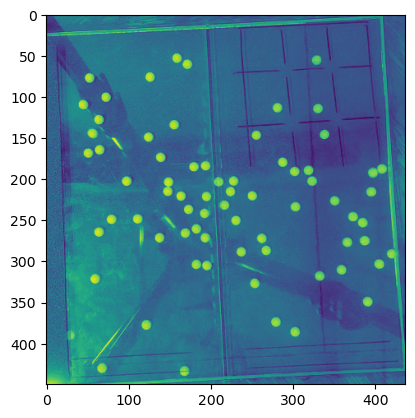

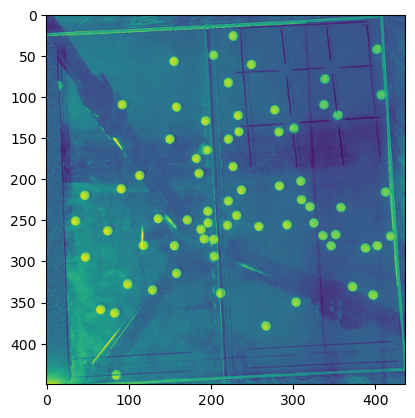

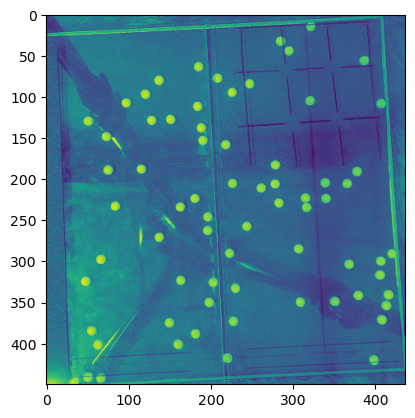

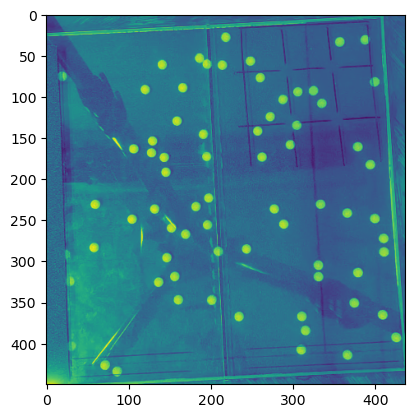

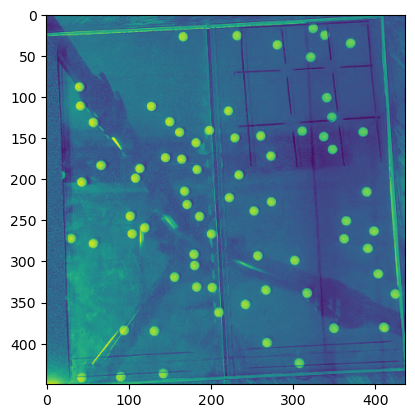

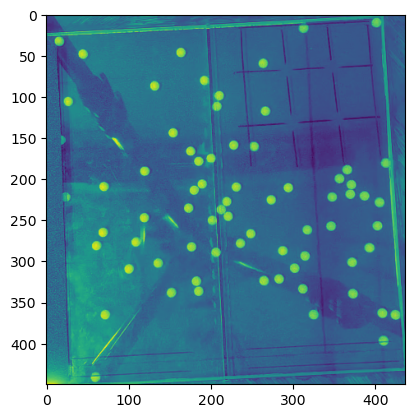

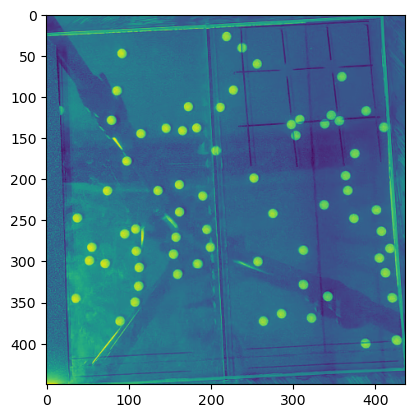

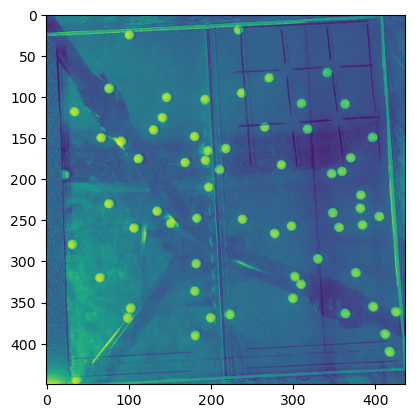

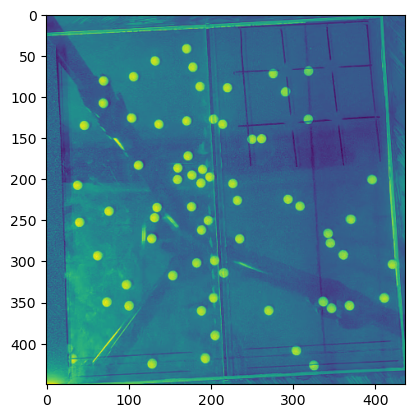

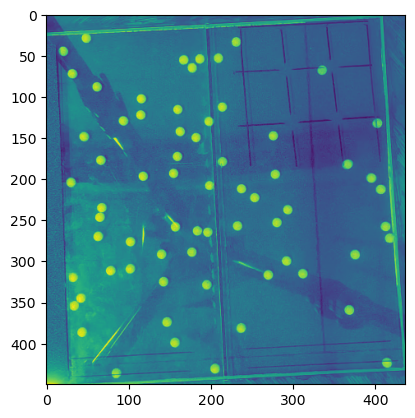

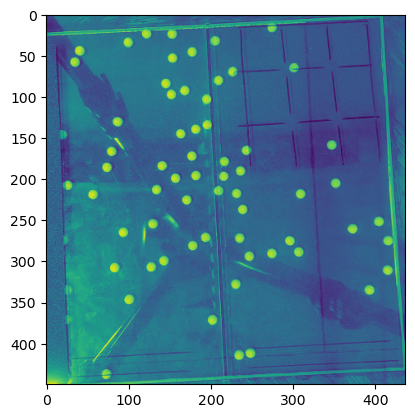

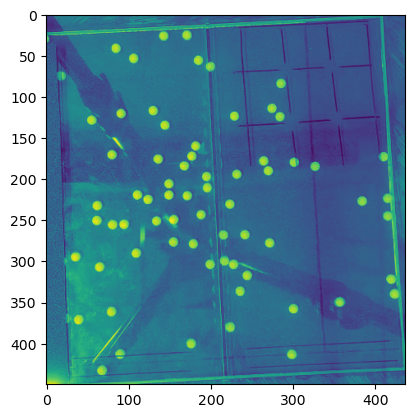

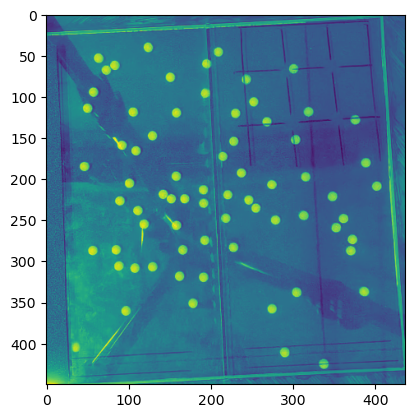

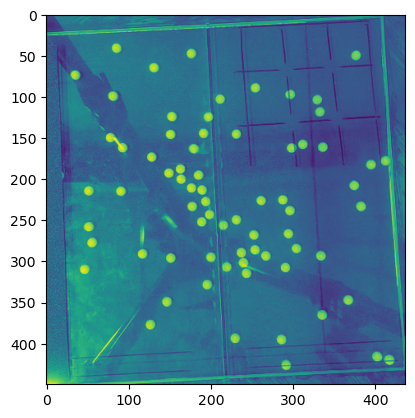

In [9]:
for i in range(len(new_frames)):
    if i % 100 == 0:
        plt.imshow(new_frames[i])
        plt.show()

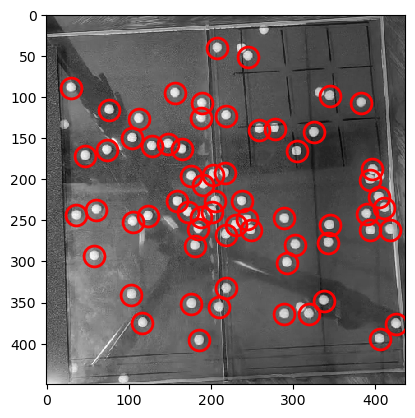

<Axes: >

In [8]:
# locates bright features with diameter of 3 pixels
f = tp.locate(new_frames[0], 13, threshold=0, minmass=3000)
f.head()  # shows the first few rows of data
	
tp.annotate(f, new_frames[0])

[Text(0.5, 0, 'mass'), Text(0, 0.5, 'count')]

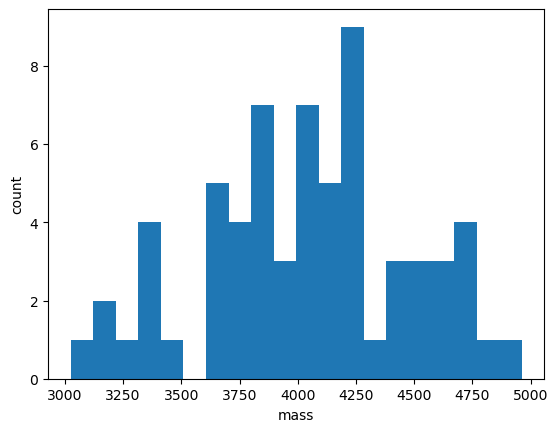

In [9]:
# clearly many of these circles are wrong, we look at total brightness ('mass') of these points
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=20)

# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count')

/Users/hervesv/opt/anaconda3/envs/IPT/lib/python3.12/site-packages/trackpy/plots.py:643: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  axlist = f[pos_columns].applymap(lambda x: x % 1).hist()


array([[<Axes: title={'center': 'x'}>, <Axes: title={'center': 'y'}>]],
      dtype=object)

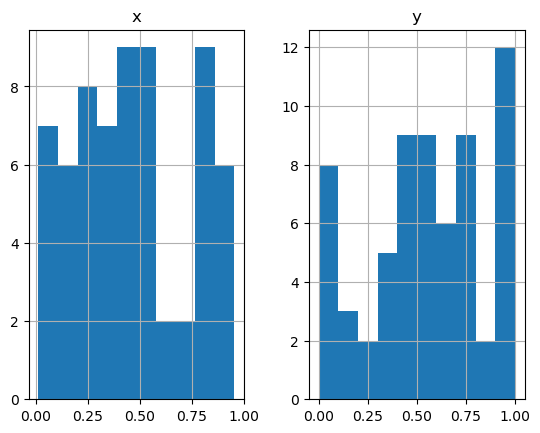

# Track on entire video

In [10]:
f = tp.batch(new_frames, 13, threshold=0, minmass=3000)

Frame 2138: 65 features


In [14]:
t.head()

y           x         mass      size       ecc     signal  \
0    40.000325  207.421253  4169.764765  3.796250  0.008172  53.146052   
35  243.533605   35.894495  3898.279837  3.708532  0.040265  59.916250   
36  242.070792  389.510234  4217.494659  3.786829  0.032467  53.484562   
37  245.792852  188.099040  3807.559188  3.650980  0.055249  55.515621   
38  247.592782  289.359591  4108.155966  3.777056  0.014753  53.484562   

      raw_mass        ep  frame  particle  
0   22869.8264  0.051171      0         0  
35  24174.2806  0.045887      0         1  
36  22490.7431  0.052943      0         2  
37  23547.2829  0.048283      0         3  
38  22638.2450  0.052239      0         4

before: 18052
after:
- memory=3 : 3125
- memory=5 : 3086
- memory=7 : 3062
- memory=10 : 3042

Frame 2138: 65 trajectories present.


In [31]:
# tp.quiet()  # Turn off progress reports for best performance
t = tp.link(f, 5, memory=3) # this tracks the location of each particle by establishing continuity from frame to frame
#t.head()

t1 = tp.filter_stubs(t, 10)
#t1 = t.copy()
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

Frame 2138: 65 trajectories present.
Before: 18052
After: 3125


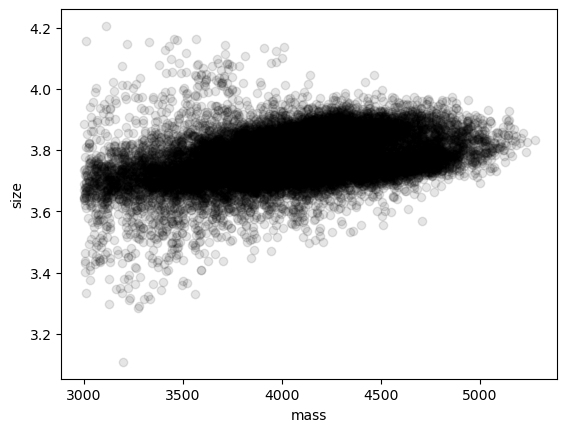

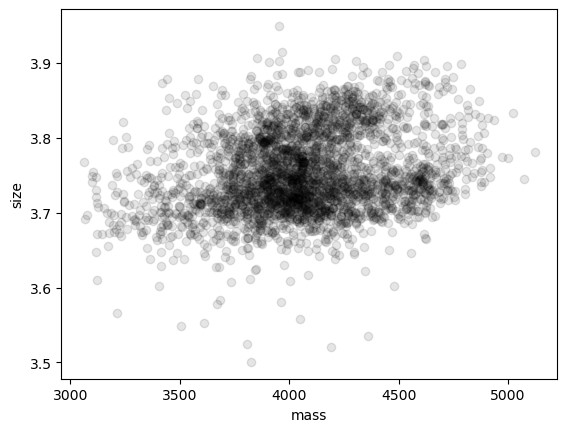

In [16]:
plt.figure()
tp.mass_size(t.groupby('particle').mean()); # convenience function -- just plots size vs. mass

plt.figure()
tp.mass_size(t1.groupby('particle').mean()); # convenience function -- just plots size vs. mass


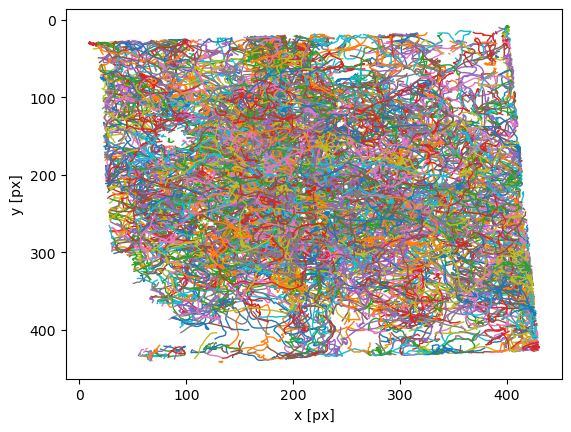

<Axes: xlabel='x [px]', ylabel='y [px]'>

In [17]:
plt.figure()
tp.plot_traj(t1)

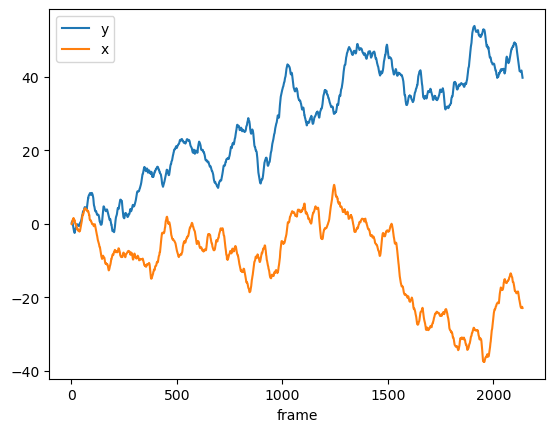

In [18]:
d = tp.compute_drift(t1)
d.plot()
plt.show()

don't subtract drift. There doesn't look to be an overall drift behaviour. Besides, assuming the table is level, there should in principle be no overall bulk drift, so I believe we should interpret these as random bulk fluctations for particle movement

# Compute mean square displacement

In [32]:
im = tp.imsd(t1, 1., 30)  # microns per pixel = 1 (just fro now), frames per second = 30



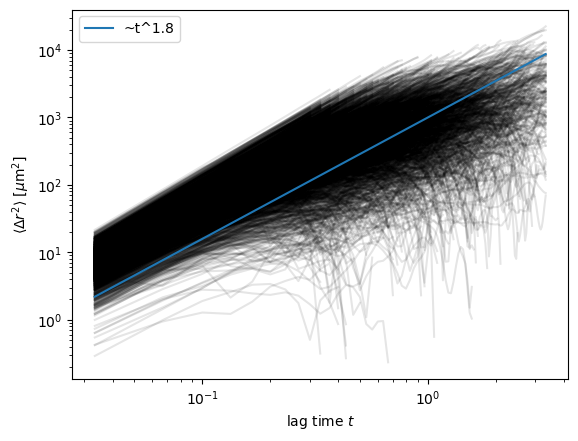

In [33]:
def poly_model(x, alpha, a):
    return a*x**alpha

fig, ax = plt.subplots()
ax.plot(im.index, im, 'k-', alpha=0.1)  # black lines, semitransparent
ax.plot(im.index, poly_model(im.index, 1.8, 1e3), label=fr"~t^1.8")
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
plt.show()


In [ ]:
em = tp.emsd(t1, 1., 30) # microns per pixel = 1., frames per second = 30


In [41]:
print(len(em.index))

100


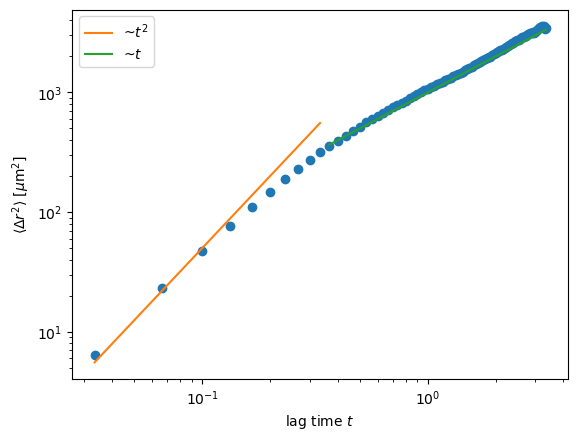

In [ ]:
fig, ax = plt.subplots()
ax.plot(em.index, em, 'o')
ax.plot(em.index[:10], poly_model(em.index[:10], 2, 5000), label=f"~$t^2$") # Ballistic motion at short timescales
ax.plot(em.index[10:], poly_model(em.index[10:], 1, 1e3), label=f"~$t$") # Brownian motion at long timescales
ax.set_xscale('log')
ax.set_yscale('log')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax.set_title("Ensemble average MSD")
ax.legend()



In [23]:
print(max(em.index))

3.3333333333333335


In [24]:

particle0 = t1[t1['particle']==0]
print(particle0)

                     y           x         mass      size       ecc  \
frame_index                                                           
0            40.000325  207.421253  4169.764765  3.796250  0.008172   
1            39.856192  208.161556  4202.261390  3.792223  0.014046   
2            40.241476  208.385274  4182.574191  3.825742  0.008486   
3            43.860632  208.420791  4164.662034  3.821202  0.019652   
4            45.847741  208.805221  4153.943409  3.801364  0.011759   
...                ...         ...          ...       ...       ...   
110          54.815424  190.662284  4070.507404  3.784915  0.004198   
111          54.649295  190.849895  4041.195046  3.780136  0.021414   
112          55.583909  189.503279  3811.782535  3.828220  0.016179   
113          56.888245  187.897747  3833.704331  3.822799  0.006939   
114          59.832638  187.512475  3305.578054  3.674968  0.018420   

                signal    raw_mass        ep  frame  particle  
frame_index 

print(particle0[particle0['frame']==0])
for i in range(len(new_frames)):
    tp.annotate(particle0[particle0['frame']==i], new_frames[i])
    plt.show()
    print(i)
    input()
    

# create array listing position of each particle

In [ ]:
particle_num = np.max(t1['particle'])
print(f"{particle_num = }")
particle_info = [t1[t1['particle']==i] for i in range(particle_num+1)]

particle_num = 17983


In [ ]:
particle_info[8]

y           x         mass      size       ecc     signal  \
frame                                                                       
0      255.884761  229.856458  3671.816724  3.657517  0.044347  51.453503   
1      255.283872  229.960769  3742.779517  3.689752  0.013414  51.941429   
2      255.129243  231.176333  3694.113459  3.693233  0.026072  52.015212   
3      255.076937  231.283280  3632.968027  3.634141  0.013819  53.334012   
4      254.820450  229.828797  3734.133434  3.675613  0.031157  51.623965   
5      254.774343  228.984726  3609.473227  3.644663  0.067091  52.178038   
6      254.904181  229.325978  3427.568562  3.639563  0.086421  50.756677   
10     255.723548  227.900489  3675.275031  3.680852  0.050211  51.112639   
11     254.568493  226.162517  3810.594450  3.706210  0.010002  51.750943   
12     252.804993  224.525976  3709.132552  3.711116  0.027455  48.858323   
13     252.786647  224.536902  3761.815945  3.714035  0.034393  50.858888   

         raw_mass        ep  frame  particle  
frame                                         
0      23552.3049  0.048263      0         8  
1      23623.2223  0.042424      1         8  
2      23652.8821  0.046829      2         8  
3      23436.7511  0.049359      3         8  
4      23672.3907  0.048150      4         8  
5      23667.1225  0.045132      5         8  
6      23683.5953  0.048660      6         8  
10     23573.0726  0.050998     10         8  
11     23271.9615  0.046397     11         8  
12     23210.1622  0.048121     12         8  
13     23291.5655  0.050480     13         8

# which particle do we distinguish for the longest amount of time?

In [ ]:
fps = 30.

frames_tracked = np.array([len(particle_info[i]) for i in range(len(particle_info))])
print(frames_tracked)
time_tracked = frames_tracked * 1/fps
print(np.max(time_tracked))

[113  14  14 ...   0   0  10]
8.466666666666667


# compute autocorrelation function for particles

# 